# Continuous ensemble training
Now that the data, the network frameworks and the training loops are set up, we can investigate fruther.

# Setting everything up

In [18]:
# Reload module in case of changes
importlib.reload(utils)

<module 'lib.utils' from '/net/projects/scratch/winter/valid_until_31_July_2022/fheitzer/BAThesis-code/notebooks/../lib/utils.py'>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys; sys.path.insert(0, '..')
import importlib

from lib import data, networks, training, utils

In [3]:
# load 10 class data
train_ds_pre, train_ds_post, test_ds, train_generator, test_generator = data.load_data(rotation=30)
dataset_shape = (tf.TensorSpec(shape=(28,28,1), dtype=tf.float64),
                tf.TensorSpec(shape=(10,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(10,), dtype=tf.float32))

num_classes = 10
# Small model
model1 = networks.NN([128, 128], num_classes)
# Broad Model
model2 = networks.NN([512], num_classes)
# Mixed Model
#model3a = networks.NN([256, 256], num_classes)

model3b = networks.CNN([(32, 3), (64, 5)])
# cnn
model4 = networks.CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = networks.CNN([(16, 3), (32, 3), (64, 5)], num_classes)
# ensemble
ensemble = networks.Ensemble([model1, model2, model3b, model4, model5])

model1.load_weights('../models/NN128128extra')
model2.load_weights('../models/NN512extra')
model3b.load_weights('../models/CNN3264extra')
model4.load_weights('../models/CNN3264128extra')
model5.load_weights('../models/CNN163264extra')

2022-05-02 10:59:01.006692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 10:59:01.070731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2496000000 Hz
2022-05-02 10:59:01.072962: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56461235e2a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-02 10:59:01.073013: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


# Investigation

## What happens if the model has to face increasingly augmented data?

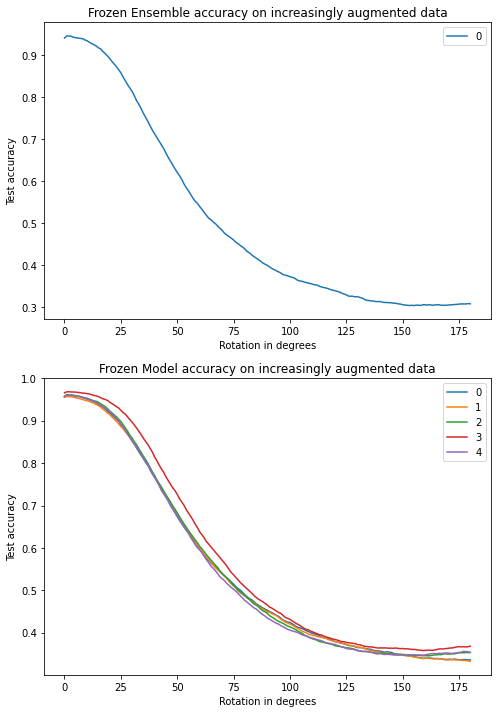

In [11]:
utils.plot_frozen_model('Frozenmodel_r180_c180')

## We should apply continuous ensemble training!

*Starting off with a cycle size of 15.000*

### How does the method react to different jumps in augmentation?

In [7]:
jumpfiles = ["Jump_r5_e1_b1_c24_d15000",
             "Jump_r10_e1_b1_c24_d15000",
             "Jump_r20_e1_b1_c24_d15000",
             "Jump_r25_e1_b1_c24_d15000"]

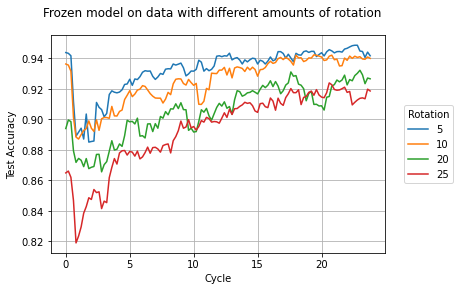

In [32]:
utils.plot_multiple_ensemble_accuracies(jumpfiles, "Jump")

### What augmentation speed can the method handle?

In [5]:
files = ["Increment_r180_e1_b1_c36_d15000",
         "Increment_r180_e1_b1_c60_d15000", 
         "Increment_r180_e1_b1_c90_d15000", 
         "Increment_r90_e1_b1_c90_d15000", 
         "Increment_r180_e1_b1_c360_d15000",
         "Increment_r30_e1_b1_c90_d15000",
         "Increment_r180_e1_b1_c900_d15000"]

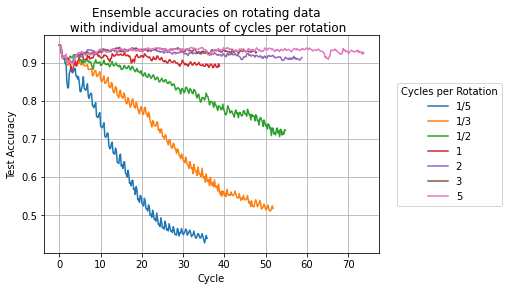

In [30]:
utils.plot_multiple_ensemble_accuracies(files, "Increment")

### Does the continously trained model still perform well on the original data?

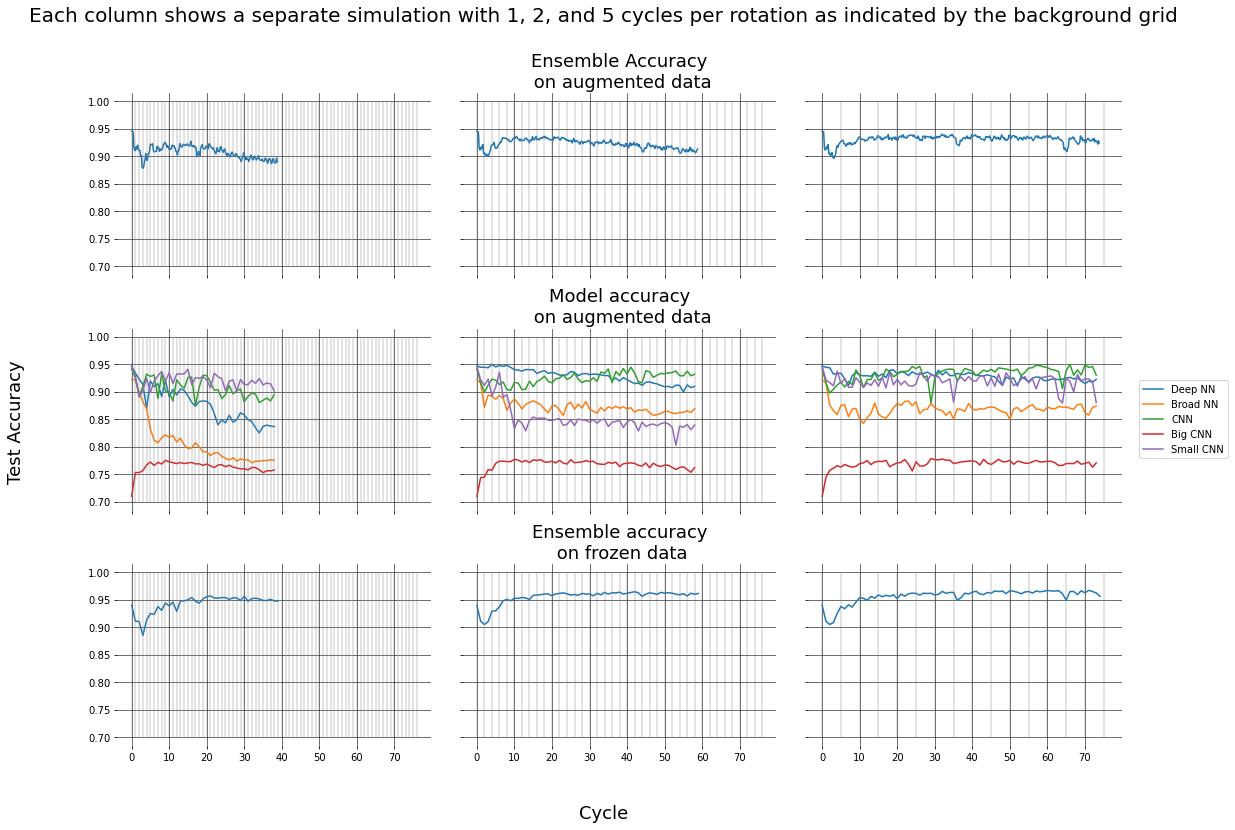

In [57]:
utils.plot_cycle_accuracies_grid(files[3:-2] + [files[-1]])

**Continuous ensemble training allows for stable performance in a changing environment whithout a decrease in performance on the original data.**

## What if there is less or more data per cycle?

In [8]:
paths = ["datapercyclecomparison_r20_e1_b1_c100_d3000",
         "Increment_r90_e1_b1_c90_d15000",
         "lessdata_r50_e1_b1_c250_d5000",
         "lessdata_r50_e1_b1_c250_d10000",
         "Increment_r180_e1_b1_c900_d15000"]

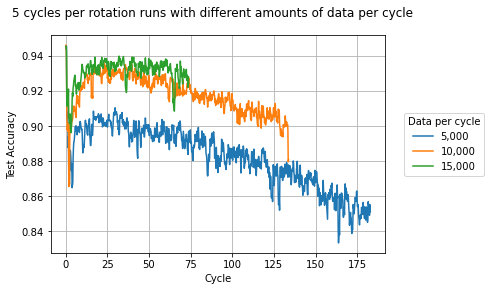

In [9]:
utils.plot_multiple_ensemble_accuracies(paths[2:], "5cr_comparison")

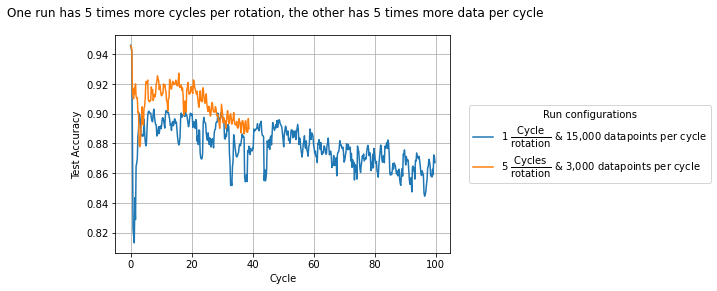

In [19]:
utils.plot_multiple_ensemble_accuracies(paths[:2], "1cr15k_5cr3k")

In [ ]:
utils.plot_multiple_ensemble_accuracies(paths[-2:], "1cr15k_5cr3k")

## What does the collected data show?

### $1 \frac{\text{Cycle}}{\text{Degree of rotation}}$
(90 degrees in 39/90 cycles)

Cycle:  0
7701.0 collected datapoints labeled correct
328.0 collected datapoints were labeled wrong
544 datapoints were not classified.


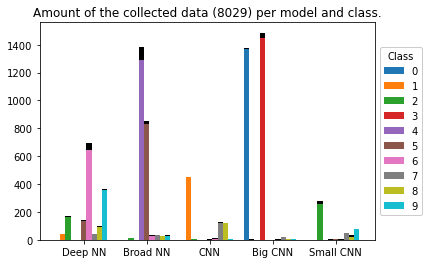

In [29]:
utils.plot_cycles_oneline(ensemble, "Increment_r90_e1_b1_c90_d15000", only_some=[-2,-1])

### $2 \frac{\text{Cycles}}{\text{Degree of rotation}}$
(180 degrees in 59/360 cycles)

6787.0 collected datapoints labeled correct
238.0 collected datapoints were labeled wrong
271 datapoints were not classified.


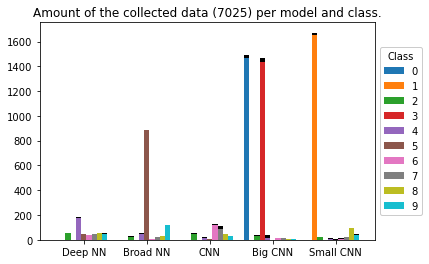

In [72]:
utils.plot_cycles_oneline(ensemble, "Increment_r180_e1_b1_c360_d15000", only_some=[-2,-1])

### $3 \frac{\text{Cycles}}{\text{Degree of rotation}}$
(30 degrees in 48/90 cycles)

Cycle:  0
5872.0 collected datapoints labeled correct
234.0 collected datapoints were labeled wrong
187 datapoints were not classified.


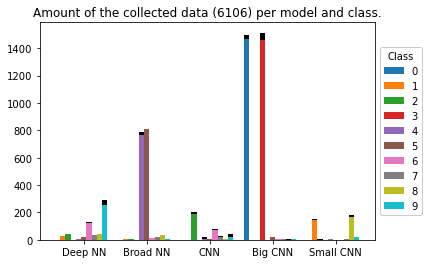

In [43]:
utils.plot_cycles_oneline(ensemble, "Increment_r30_e1_b1_c90_d15000", only_some=[-2,-1])

## Can we evaluate the specialization?

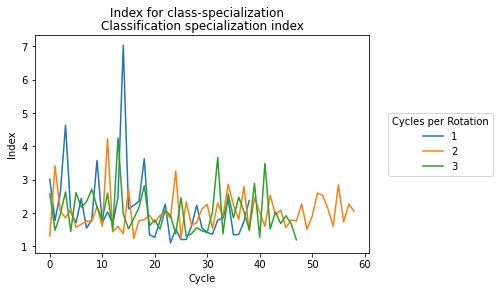

In [55]:
utils.classification_specialization_mean(ensemble,
                                         ["Increment_r90_e1_b1_c90_d15000",
                                          "Increment_r180_e1_b1_c360_d15000",
                                          "Increment_r30_e1_b1_c90_d15000"],
                                         legend=["1","2","3"])

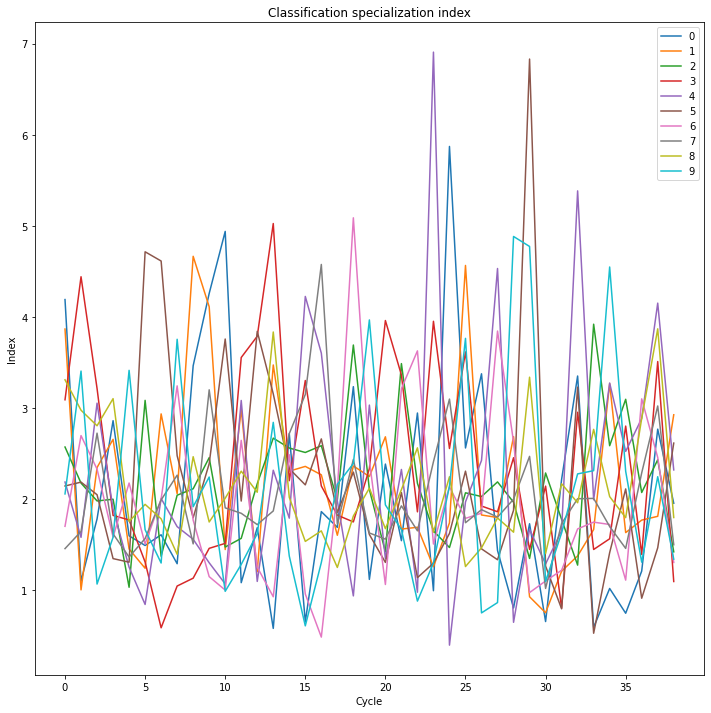

In [35]:
utils.classification_specialization(ensemble, "Increment_r90_e1_b1_c90_d15000")